In [1]:
%matplotlib inline

In [2]:
import numpy as np
import xarray as xr
from scipy import signal

In [3]:
from xrbispectral import calculate_bispectral

In [4]:
from dask.diagnostics import ProgressBar

A signal containing frequencies $f_1$, $f_2$ and $f_1+f_2$ which are all in phase is created and its complex spectrum is estimated.

In [5]:
N = 2**16
x = np.arange(N)        # time
NFFT = 32
w = 2*np.pi*np.fft.fftfreq(NFFT) # angular frequencies
i, j = 3, 9                      # selected frequency indices
y = np.sin(w[i]*x) + np.sin(w[j]*x) + np.sin(w[i+j]*x) # signal
# the spectrum of the signal is calculated for several windows (for averaging)
f, t, s = signal.spectrogram(y, fs=1.0, window='boxcar', nperseg=NFFT, 
                             scaling='spectrum',
                             mode='complex', return_onesided=False, noverlap=0)
xs = xr.DataArray(s, coords=[('f', f), ('t', t)], name='sample_spectrum')
xs.attrs['base_fs'] = xs.f.isel(f=[i,j]).values
xs = xs.sortby('f')

The power spectral density contains these frequencies as expected.

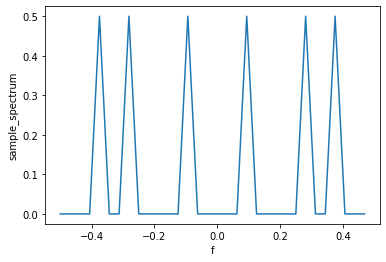

In [6]:
psd = np.abs(xs).mean(dim='t').plot()

The bispectrum and bicoherence are created as Dask arrays and are evaluated (possibly in a parallelized way) on demand.

In [7]:
bisp_ds = calculate_bispectral(xs, freq_dim='f', avg_dim='t')
bisp_ds

<xarray.Dataset>
Dimensions:      (f: 15, f1: 15)
Coordinates:
  * f1           (f1) float64 0.03125 0.0625 0.09375 ... 0.4062 0.4375 0.4688
  * f            (f) float64 0.03125 0.0625 0.09375 ... 0.4062 0.4375 0.4688
Data variables:
    bispectrum   (f1, f) complex128 dask.array<shape=(15, 15), chunksize=(1, 15)>
    n1_norm      (f1) float64 6.56e-25 2.097e-25 0.25 ... 3.232e-25 2.228e-25
    n_norm       (f) float64 6.56e-25 2.097e-25 0.25 ... 3.232e-25 2.228e-25
    v_norm       (f1, f) float64 dask.array<shape=(15, 15), chunksize=(1, 15)>
    norm         (f1, f) float64 dask.array<shape=(15, 15), chunksize=(1, 15)>
    bicoherence  (f1, f) float64 dask.array<shape=(15, 15), chunksize=(1, 15)>

In [8]:
with ProgressBar():
    bicoh = bisp_ds.bicoherence.compute()

[########################################] | 100% Completed |  0.2s


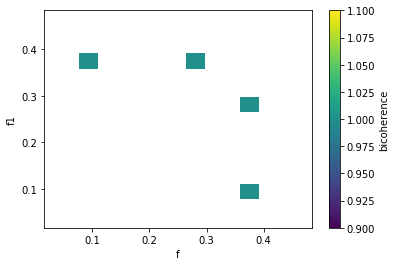

In [9]:
bicoh.plot()